In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

from omfit_classes.omfit_eqdsk import boundaryShape

In [3]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          aba6d8f
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('nextstep_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2,F0=1*3)



**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  5.098E+00
    # of points  =    5677
    # of edges   =   16908
    # of cells   =   11232
    # of boundary points =     120
    # of boundary edges  =     120
    # of boundary cells  =     120
  Resolution statistics:
    hmin =  3.000E-03
    hrms =  3.455E-02
    hmax =  1.152E-01
  Surface grounded at vertex    1537


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.7309999999999999E-003


In [5]:

d = -0.5
e = 1.7

coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = 0.5*np.ones(mygs.ncoils+1)
coil_weights[1:3] = 5

#Set target values for CS coils
coil_reg_mat[0,0] = 1
coil_reg_mat[1,1] = 1
coil_reg_mat[1,0] = -1
coil_reg_mat[2,2] = 1
coil_reg_mat[2,1] = -1

targets[0] = -3E6

#Enforce up/down symmetry in PF coils
coil_reg_mat[3,3] = 1
coil_reg_mat[3,7] = -1
coil_reg_mat[4,4] = 1
coil_reg_mat[4,8] = -1
coil_reg_mat[5,5] = 1
coil_reg_mat[5,9] = -1
coil_reg_mat[6,6] = 1
coil_reg_mat[6,10] = -1
mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

#Set upper bound on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
coil_bounds[-5:-1, 0] = -122448.979592
coil_bounds[-5:-1, 1] = 122448.979592
mygs.set_coil_bounds(coil_bounds)

# Define shape of P' anf FF' profiles
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)
# Set F*F' profile
alpha = 2
gamma = 3
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
# Set P' profile
alpha = 2
gamma = 3
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

# set global targets
Ip_target = 1E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

# set boundary/saddle point targets
r, z, zeff = boundaryShape(kapu = 1.7, kapl = 1.7, delu = -0.5, dell = -0.5, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/1, zoffset = 0, upnull = True, lonull = True, npts = 8)
boundary = np.column_stack((r,z))
boundary = np.nan_to_num(boundary)
x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
x_weights = 50*np.ones(2)
mygs.set_saddles(x_points, x_weights)

strike_ul = [1.06, 0.55]
strike_ur = [1.255, 0.495]

strike_ll = np.copy(strike_ul)
strike_ll[1] = -strike_ul[1]
strike_lr = np.copy(strike_ur)
strike_lr[1] = -strike_ur[1]

boundary = np.vstack((boundary, strike_ul, strike_ll, strike_lr, strike_ur))
isoflux_weights = 50*np.ones(len(boundary))
isoflux_weights[-4:] = 500

mygs.set_isoflux(boundary, isoflux_weights)

#find equilibrium
mygs.init_psi(0.68,0,0.2, 1.8,0.3)
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()


Starting non-linear GS solver
     1  1.1887E+01  5.6388E+00  9.9770E-02  1.0353E+00  6.1183E-05 -0.0000E+00
     2  1.2379E+01  5.8905E+00  1.8737E-02  1.0366E+00  2.9463E-05 -0.0000E+00
     3  1.2674E+01  6.0369E+00  3.7257E-03  1.0371E+00  1.3375E-05 -0.0000E+00
     4  1.2858E+01  6.1275E+00  1.2048E-03  1.0372E+00  2.6141E-06 -0.0000E+00
     5  1.2969E+01  6.1822E+00  6.3828E-04  1.0372E+00 -5.4499E-06 -0.0000E+00
     6  1.3034E+01  6.2144E+00  3.5868E-04  1.0372E+00 -1.1510E-05 -0.0000E+00
     7  1.3072E+01  6.2331E+00  1.9988E-04  1.0372E+00 -1.5995E-05 -0.0000E+00
     8  1.3093E+01  6.2439E+00  1.1120E-04  1.0371E+00 -1.9341E-05 -0.0000E+00
     9  1.3106E+01  6.2500E+00  6.2038E-05  1.0371E+00 -2.1870E-05 -0.0000E+00
    10  1.3112E+01  6.2535E+00  3.4749E-05  1.0371E+00 -2.3788E-05 -0.0000E+00
    11  1.3116E+01  6.2555E+00  1.9536E-05  1.0371E+00 -2.5248E-05 -0.0000E+00
    12  1.3119E+01  6.2566E+00  1.1021E-05  1.0371E+00 -2.6360E-05 -0.0000E+00
    13  1.3120E+01  6.

0

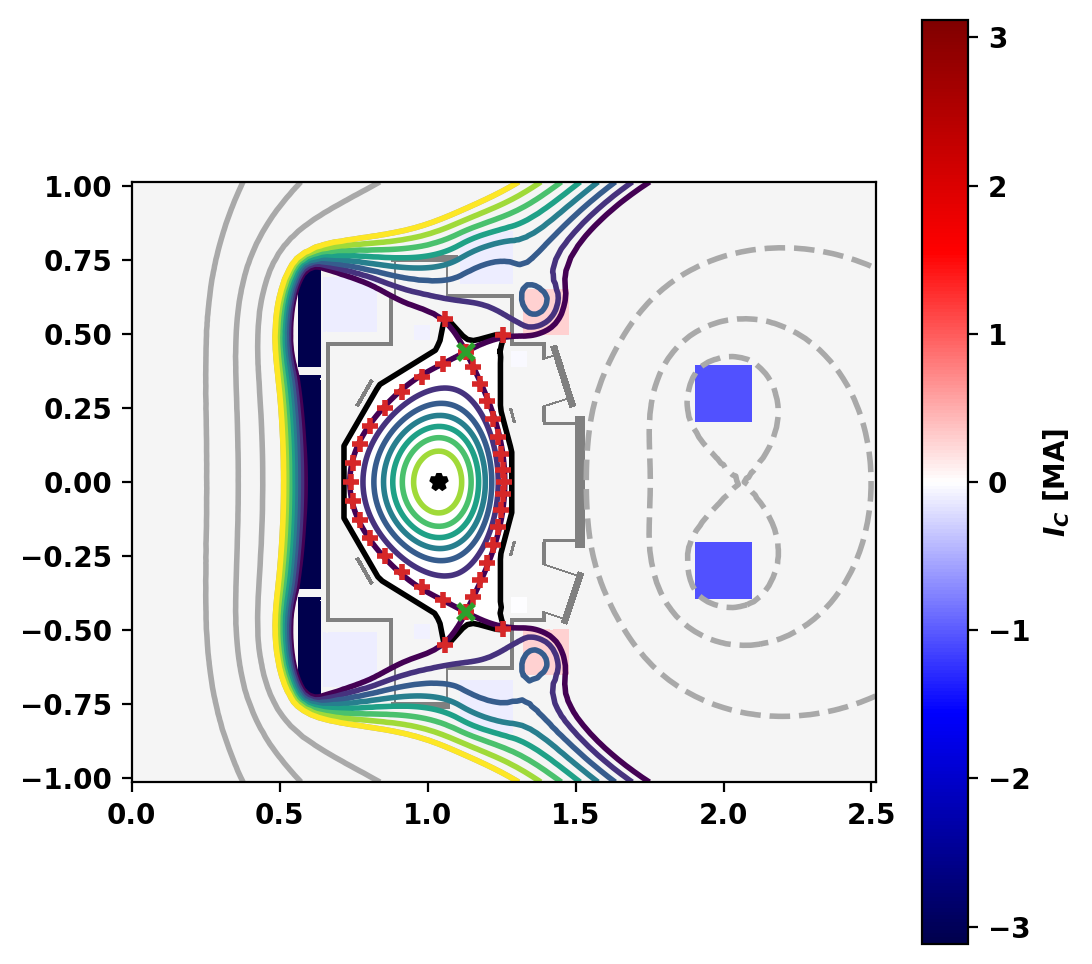

In [6]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
mygs.plot_constraints(fig,ax)
#plt.xlim([1,1.5])
#plt.ylim([0.25, 0.75])


In [7]:
mygs.print_info()

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    9.9999E+05
  Current Centroid [m]    =    1.028 -0.000
  Magnetic Axis [m]       =    1.037 -0.000
  Elongation              =    1.635 (U:  1.573, L:  1.698)
  Triangularity           =   -0.455 (U: -0.411, L: -0.499)
  Plasma Volume [m^3]     =    2.009
  q_0, q_95               =    0.477  1.682
  Peak Pressure [Pa]      =    4.3031E+05
  Stored Energy [J]       =    2.3053E+05
  <Beta_pol> [%]          =   52.3130
  <Beta_tor> [%]          =    2.2552
  Diamagnetic flux [Wb]   =    9.9919E-03
  Toroidal flux [Wb]      =    9.4607E-01
  l_i                     =    1.4040


Starting CG solver
     0  0.000000E+00  0.000000E+00  1.195248E+00
     1 -1.936299E+04  4.047404E+04  2.884798E-01  7.127525E-06
     2 -2.016504E+04  4.380717E+04  1.356691E-01  3.096962E-06
     3 -2.030775E+04  4.413848E+04  4.931783E-02  1.117343E-06
     4 -2.032042E+04  4.430264E+04  2.032724E-02  4.588269E-07
     5 -2.032189E+04  4.423610E+04  8.237856E-03  1.862248E-07
     6 -2.032209E+04  4.423737E+04  3.298405E-03  7.456150E-08
     7 -2.032213E+04  4.423609E+04  1.159378E-03  2.620887E-08
     8 -2.032213E+04  4.423764E+04  4.006281E-04  9.056271E-09
     9 -2.032213E+04  4.423787E+04  1.652274E-04  3.734978E-09
    10 -2.032213E+04  4.423802E+04  7.139243E-05  1.613825E-09
    20 -2.032213E+04  4.423800E+04  4.339969E-09  9.810501E-14
Growth rate = 2.1649E+02 [s^-1]
Growth time = 4.6191E-03 [s]


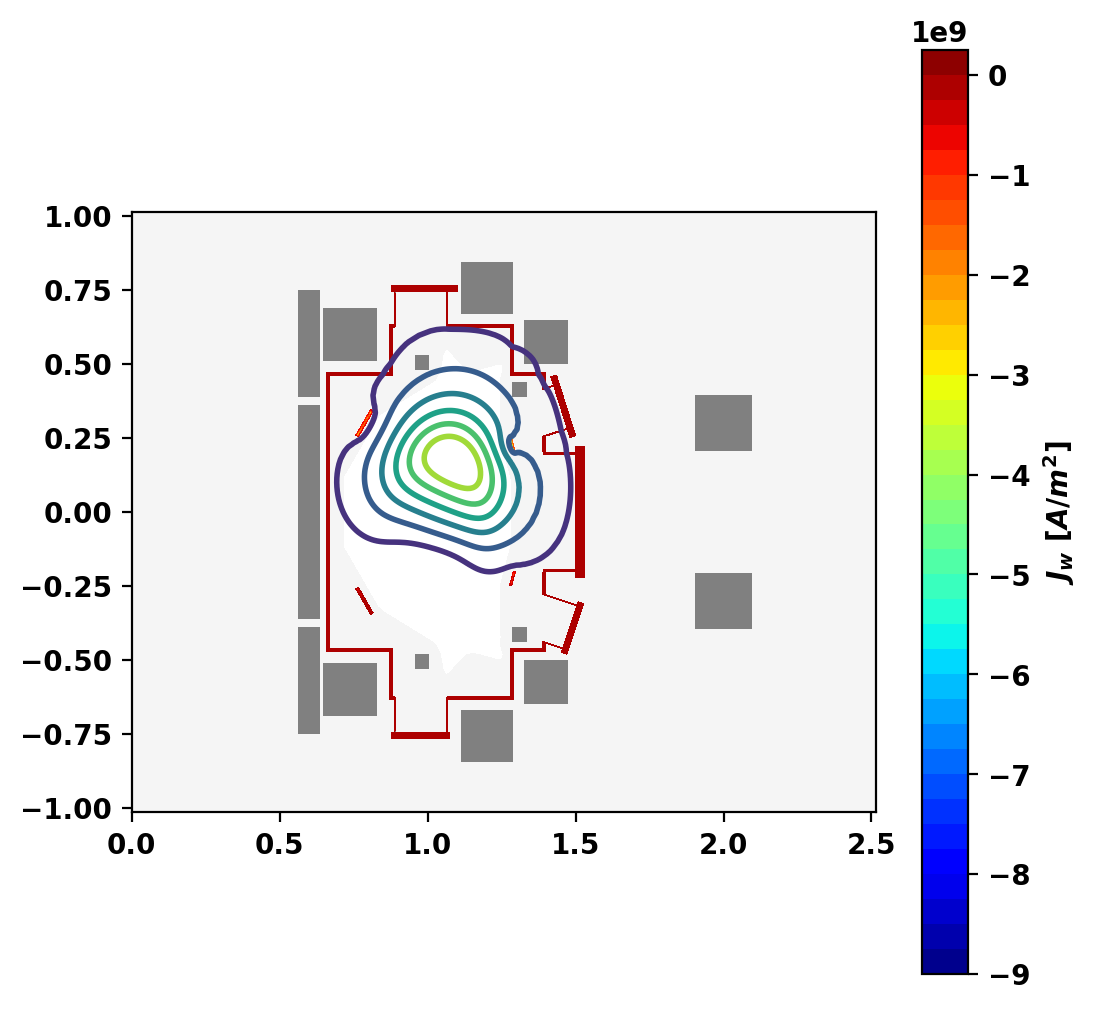

In [8]:
eig_vals, eig_vecs = mygs.eig_td(-5.E3,10,True) 
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,eig_vecs[0,:],normalized=False,xpoint_color=None,opoint_color=None)
mygs.plot_eddy(fig,ax,-eig_vecs[0,:]*eig_vals[0,0])
print('Growth rate = {0:.4E} [s^-1]'.format(-eig_vals[0,0]))
print('Growth time = {0:.4E} [s]'.format(-1.0/eig_vals[0,0]))

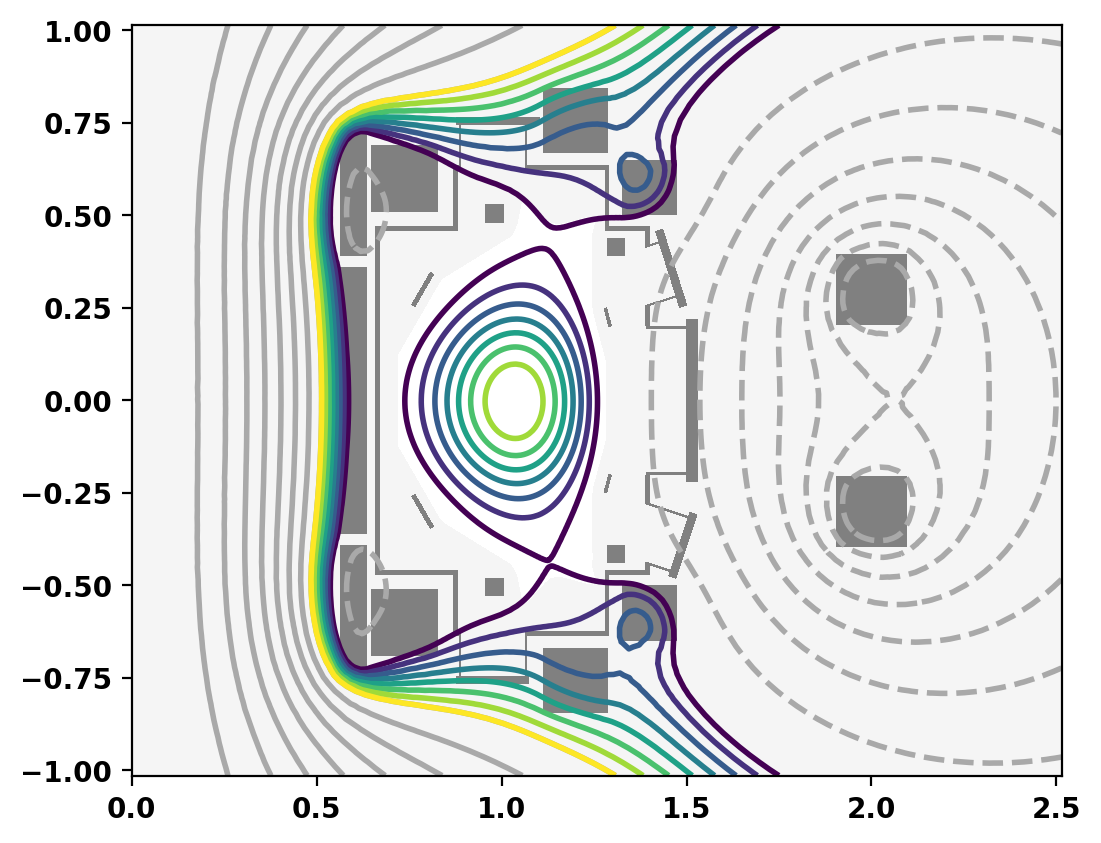

In [9]:
psi0 = mygs.get_psi(normalized = False)
max_loc = abs(eig_vecs[0,:]).argmax()
psi_ic = psi0-eig_vecs[0,:]*(mygs.psi_bounds[1]-mygs.psi_bounds[0])/eig_vecs[0,max_loc]/50.0

fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,(psi_ic-mygs.psi_bounds[1])/(mygs.psi_bounds[0]-mygs.psi_bounds[1]),xpoint_color=None,opoint_color=None)
mygs.set_psi(psi_ic)

In [10]:
mygs.settings.pm=False
mygs.update_settings()
mygs.set_isoflux(None)
mygs.set_targets(Ip=1E6,Ip_ratio=1)
mygs.setup_td(1.E-03,1.E-13,1.E-11,pre_plasma=False)

In [11]:
import time
sim_time = 0.0
dt = 1.E-1/-eig_vals[0,0]
nplot = 1
nstatus = 1
results = [mygs.get_psi()]
results_raw = [mygs.get_psi(False)]
z0 = [[sim_time,mygs.o_point[1]],]
eig_comp = [[sim_time,np.dot(eig_vecs[0,:],mygs.get_psi(normalized=False)-psi0)],]
t00 = time.perf_counter()
q = []

for i in range(35):
    t0 = time.perf_counter()
    sim_time, _, nl_its, lin_its, nretry = mygs.step_td(sim_time,dt)
    t1 = time.perf_counter()
    if i % nstatus == 0:
        print('{0:.5E} {1:.5E} {2:4d} {3:4d} {5:8.3f} {4:4d}'.format(sim_time,dt,nl_its,lin_its,nretry,t1-t0))
    z0.append([sim_time,mygs.o_point[1]])
    eig_comp.append([sim_time,np.dot(eig_vecs[0,:],mygs.get_psi(normalized=False)-psi0)])
    q_prof = mygs.get_q()
    if i % nplot == 0:
        results.append(mygs.get_psi())
        results_raw.append(mygs.get_psi(False))
        psi,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q(psi = 0.95)
        q.append(qvals[0])
t1 = time.perf_counter()
print('Total time = {0:8.3f}'.format(t1-t00))

4.61914E-04 4.61914E-04    2   18    0.334    0
9.23828E-04 4.61914E-04    2   15    0.169    0
1.38574E-03 4.61914E-04    2   15    0.171    0
1.84766E-03 4.61914E-04    2   17    0.202    0
2.30957E-03 4.61914E-04    2   18    0.196    0
2.77148E-03 4.61914E-04    2   18    0.198    0
3.23340E-03 4.61914E-04    2   18    0.209    0
3.69531E-03 4.61914E-04    2   18    0.281    0
4.15723E-03 4.61914E-04    2   18    0.220    0
4.61914E-03 4.61914E-04    2   18    0.195    0
5.08105E-03 4.61914E-04    2   18    0.195    0
5.54297E-03 4.61914E-04    2   18    0.198    0
6.00488E-03 4.61914E-04    2   18    0.194    0
6.46679E-03 4.61914E-04    2   18    0.195    0
6.92871E-03 4.61914E-04    2   17    0.186    0
7.39062E-03 4.61914E-04    2   18    0.195    0
7.85254E-03 4.61914E-04    2   19    0.202    0
8.31445E-03 4.61914E-04    2   19    0.204    0
8.77636E-03 4.61914E-04    2   19    0.204    0
9.23828E-03 4.61914E-04    2   19    0.206    0
9.70019E-03 4.61914E-04    2   19    0.2

In [12]:
print(q)

[1.6562012618214597, 1.653534978324917, 1.6505649231513289, 1.6472554165142563, 1.6435800637568403, 1.6395594402442466, 1.6351749332375531, 1.6303419327669275, 1.625067441266673, 1.6192213359256982, 1.6128773088152752, 1.6059843102037126, 1.5984812053579325, 1.5903218703830944, 1.5814737018509806, 1.5719433005095769, 1.5614922228873047, 1.5502117623016516, 1.5380811929132947, 1.5248607193499264, 1.51070809696476, 1.495394275906663, 1.4787946666351985, 1.4607647164481112, 1.4410737125505801, 1.4196134142565946, 1.3960237834386957, 1.3697907127604207, 1.3406002994016852, 1.307235179178965, 1.2682361952794743, 1.2201062812220156, 1.1539113780107502, 1.10766460492073, 1.0056046028686958]


Text(0, 0.5, '$q_{95}$')

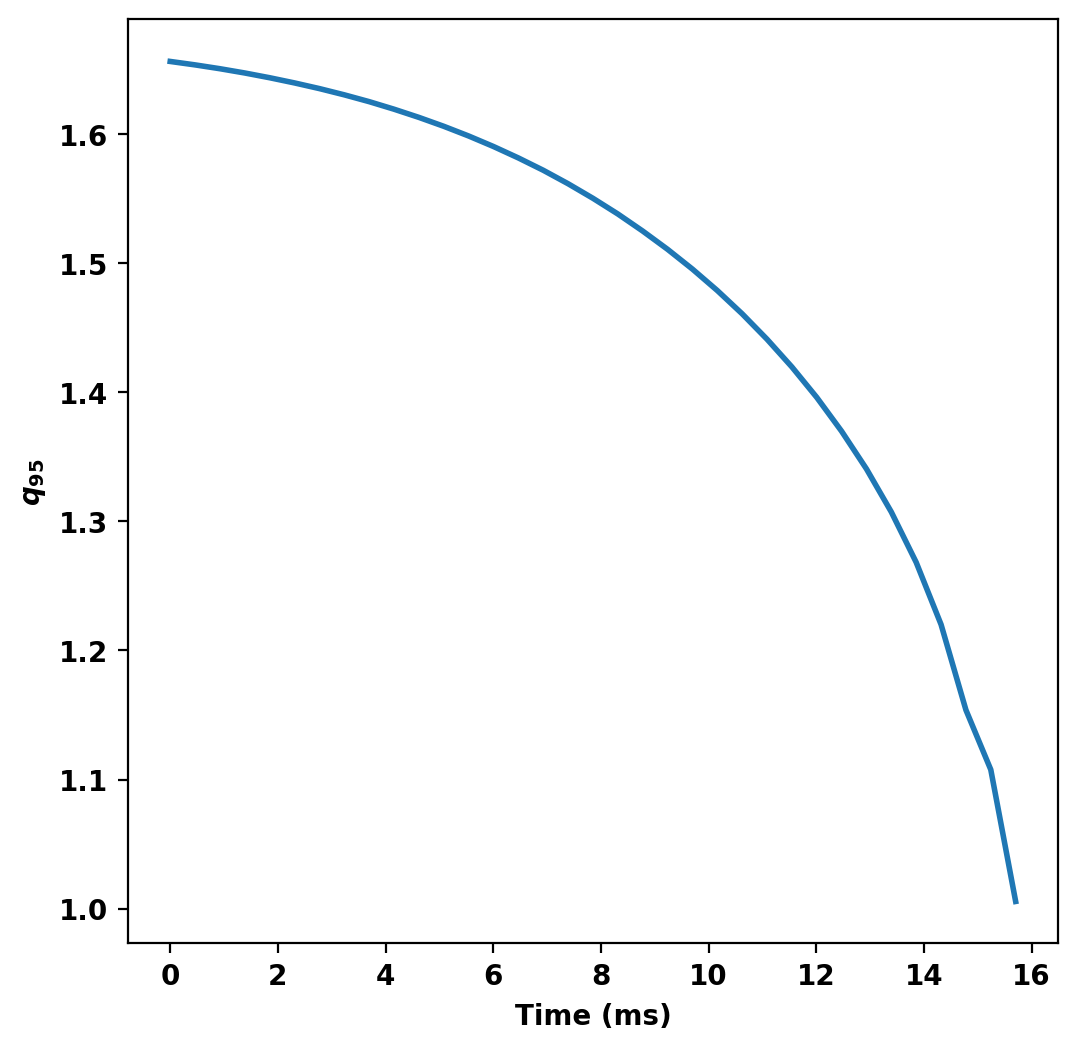

In [20]:
plt.plot(np.linspace(0,sim_time*1000, len(q)), q)
plt.xlabel('Time (ms)')
plt.ylabel(r'$q_{95}$')

Text(0, 0.5, 'Z (m)')

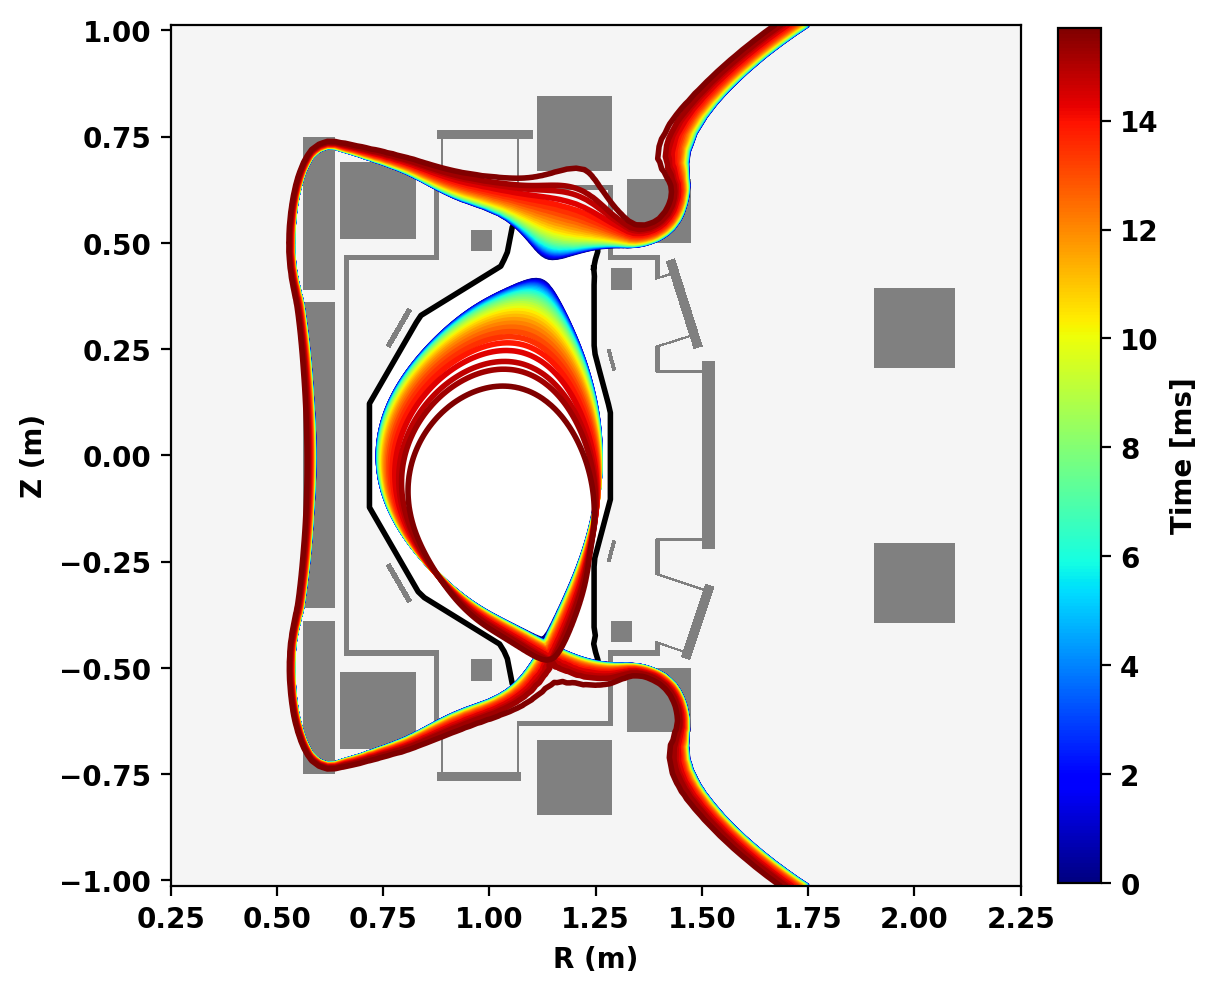

In [13]:
import matplotlib as mpl
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax)
colors = plt.cm.jet(np.linspace(0,1,len(results)))
for i, result in enumerate(results):
    mygs.plot_psi(fig,ax,psi=result,plasma_nlevels=1,plasma_color=[colors[i]], vacuum_nlevels = 0,xpoint_color=None,opoint_color=None)
norm = mpl.colors.Normalize(vmin=0.0, vmax=sim_time*1.E3)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet), ax = ax,label='Time [ms]',fraction=0.046, pad=0.04)
plt.xlim([0.25, 2.25])
plt.xlabel('R (m)')
plt.ylabel('Z (m)')